In [1]:

using JSON
using Glob
using Dates
using Plots
using ProgressMeter
using DataFrames
using CSV


include("../src/modelHDSparse.jl")
include("../src/encoding.jl")
include("../src/coarseEncoding.jl")


encodeDataset2SparseMat (generic function with 1 method)

## Generate Test Data

In [3]:

struct Data3D
    
    x::Float64
    y::Float64
    z::Float64
    
end

dist3D(pt1::Data3D, pt2::Data3D) = (pt1.x-pt2.x)^2 + (pt1.y-pt2.y)^2 + (pt1.z-pt2.z)^2


nData = 500000
data = [Data3D(0., 0., 0.)]
while length(data) < nData
    x, y, z = 2*rand()-1, 2*rand()-1, 2*rand()-1
    if x^2 + y^2 + z^2 < 1.
        push!(data, Data3D(x, y, z))
    end
end


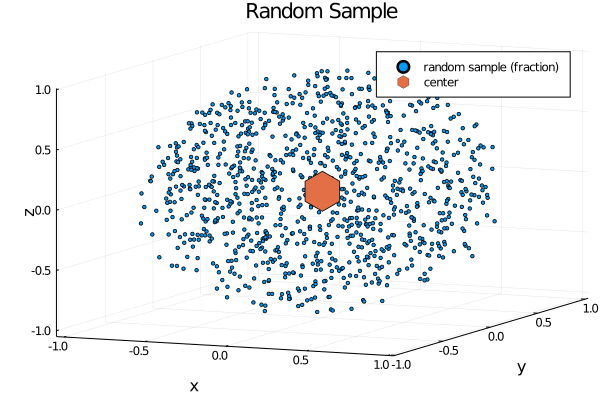

In [4]:

scatter(map(d -> d.x, data[1:1000]),
        map(d -> d.y, data[1:1000]),
        map(d -> d.z, data[1:1000]),
        label="random sample (fraction)", marker=(:circle,2,1.))

scatter!([data[1].x], [data[1].y], [data[1].z],
         label="center", marker=(:hexagon, 20, 1.), 
         xlabel = "x", ylabel="y", zlabel="z", title="Random Sample")


### Specify Coarse Encoding

In [6]:
include("Lib/coarseEncoding.jl")


dimensions = [:x,:y,:z]
nLattices = 1


maximas = Dict(:x => maximum(map(d -> d.x, data)),
               :y => maximum(map(d -> d.y, data)),
               :z => maximum(map(d -> d.z, data)))

minimas = Dict(:x => minimum(map(d -> d.x, data)),
               :y => minimum(map(d -> d.y, data)),
               :z => minimum(map(d -> d.z, data)))

resolution = Dict(:x => 0.3,
                  :y => 0.3, 
                  :z => 0.3)


@time coarseEncoder = CoarseEncoder(dimensions,nLattices,maximas,minimas,resolution)
@time lattice = generateLattice(coarseEncoder);


ErrorException: could not open file /home/jair/WORK/HDComputing.jl/examples/Lib/coarseEncoding.jl

### Encode Data

In [7]:

@time sparseHDM = encodeData2Sparse(map(d -> Dict(:x => d.x, :y => d.y, :z => d.z), data), 
                                    coarseEncoder, lattice);


UndefVarError: UndefVarError: encodeData2Sparse not defined

### Compare Searches && Sizes

#### Sizes

In [10]:
println("size of HD data: ", Base.summarysize(sparseHDM))
println("size of 3D data: ", Base.summarysize(data))

UndefVarError: UndefVarError: sparseHDM not defined

#### HD Search

In [12]:
hdvec = sparseHDM[1,:]
# time to compute distances
@time [sparseHDM * hdvec for i=1:100];
# time to filter
@time [(res = sparseHDM * hdvec;
        filter(idval -> idval[2] > 2.,  collect(zip(res.nzind, res.nzval)))) for i=1:100];

UndefVarError: UndefVarError: sparseHDM not defined

#### Cartesian Search

In [14]:
center = data[1]
@time [map(i -> dist3D(center, data[i]), 1:nData) for j=1:100]
@time [filter(i -> dist3D(center, data[i]) < 0.1, 1:nData) for j=1:100];

  6.064832 seconds (100.15 M allocations: 2.617 GiB, 32.03% gc time)
  5.208612 seconds (100.13 M allocations: 2.627 GiB, 9.64% gc time)


## Fuzziness VS Precision

In [16]:

aLattices = [2,2,5,5,20,20,40,40]
aColours = [:blue, :blue, :green, :green, :magenta, :magenta, :red, :red]
reso1 = Dict(:x => 0.2, :y => 0.2, :z => 0.2)
reso2 = Dict(:x => 0.1, :y => 0.1, :z => 0.1)
resolutions = [reso1, reso2, reso1, reso2, reso1, reso2, reso1, reso2]

ps = []
for i = 1:8
    nLattices = aLattices[i]
    colour = aColours[i]
    resolution = resolutions[i]
    
    @time coarseEncoder = CoarseEncoder(dimensions,nLattices,maximas,minimas,resolution)
    @time lattice = generateLattice(coarseEncoder)
    @time sparseHDM = encodeData2Sparse(map(d -> Dict(:x => d.x, :y => d.y, :z => d.z), data),
                                        coarseEncoder, lattice)
    
    hdvec = sparseHDM[1,:]
    res = sparseHDM * hdvec
    distsHD = map(i -> res[i], 1:nData)

    center = data[1]
    dists2D = map(i -> dist3D(center, data[i]), 1:nData)
    
    dd = map(y -> filter(i -> distsHD[i] == y, 1:nData) |>
                (I ->  map(i -> dists2D[i], I)) |>
                    (D -> Dict(:y => y, :max => maximum(D), :min => minimum(D))),
             unique(distsHD))
    x = map(d -> [d[:min], d[:max]], collect(dd))
    y = map(d -> [d[:y], d[:y]], collect(dd)) / nLattices
    
    
    reso = resolution[:x]
    p = plot(x, y, label="", #hcat([["$nLattices"];["" for i in 1:length(y)-1]]...),
             colour=[colour colour],
             xlim=(0., .15),
             title="resol: $reso nLatt: $nLattices",
             xlabel="HD similarity", ylabel="2D distance")
    push!(ps, p)
    
end

UndefVarError: UndefVarError: dimensions not defined

In [17]:
plot(ps[1], ps[2])

BoundsError: BoundsError: attempt to access 0-element Array{Any,1} at index [1]

In [18]:
plot(ps[3], ps[4])

BoundsError: BoundsError: attempt to access 0-element Array{Any,1} at index [3]

In [19]:
plot(ps[5], ps[6])

BoundsError: BoundsError: attempt to access 0-element Array{Any,1} at index [5]

In [20]:
plot(ps[7], ps[8])

BoundsError: BoundsError: attempt to access 0-element Array{Any,1} at index [7]